In [6]:
import mlrose_hiive
from mlrose_hiive.generators import KnapsackGenerator
from mlrose_hiive.algorithms import GeomDecay
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('seaborn-whitegrid')

seed = 0
output_dir = 'output'
figure_dir = 'figures'
exp_name = 'KS'

problem = KnapsackGenerator.generate(seed=seed)
max_attempts = problem.get_length()

In [7]:
restarts = [i for i in range(10, 201, 20)]
rhc_runner = mlrose_hiive.RHCRunner(problem,
                                    seed=seed,
                                    experiment_name=exp_name,
                                    iteration_list=[100000],
                                    output_directory=output_dir,
                                    restart_list=restarts,
                                    max_attempts=max_attempts)
rhc_stats, rhc_curve = rhc_runner.run()

Running rhc
*****************
*** Run START ***
*****************
restarts:[10], max_iters:[100000], current_restart:[0]
runner_name:[rhc], experiment_name:[KS], attempt:[0], iteration:[0], done:[False], time:[0.00], fitness:[145.0000]
	[4 0 3 3 3 1 3 2 4 0]...

restarts:[10], max_iters:[100000], current_restart:[0]
runner_name:[rhc], experiment_name:[KS], attempt:[11], iteration:[23], done:[True], time:[0.01], fitness:[213.0000]
	[4 4 3 4 4 3 3 4 4 0]...

restarts:[10], max_iters:[100000], current_restart:[1]
runner_name:[rhc], experiment_name:[KS], attempt:[0], iteration:[0], done:[False], time:[0.03], fitness:[103.0000]
	[0 4 1 4 1 2 2 0 1 1]...

restarts:[10], max_iters:[100000], current_restart:[1]
runner_name:[rhc], experiment_name:[KS], attempt:[11], iteration:[25], done:[True], time:[0.03], fitness:[210.0000]
	[0 4 4 4 4 2 4 4 1 4]...

restarts:[10], max_iters:[100000], current_restart:[2]
runner_name:[rhc], experiment_name:[KS], attempt:[0], iteration:[0], done:[False], time:[

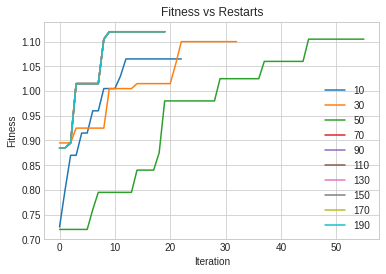

In [15]:

restarts_fit = []
ax = None
fig = plt.figure()
for re in restarts:
    rhc_curve_restart = rhc_curve[rhc_curve.Restarts == re]
    idx = rhc_curve_restart.Fitness.idxmax()
    best_restart_attempt = rhc_curve.iloc[idx].current_restart
    best_curve = rhc_curve.loc[(rhc_curve_restart.current_restart == best_restart_attempt) & (rhc_curve.Restarts == re)]
    best_curve.reset_index(inplace=True)
    best_curve['true_fit'] = best_curve.Fitness/200
    ax = best_curve['true_fit'].plot()
ax.set_xlabel("Iteration")
ax.set_ylabel("Fitness")
ax.legend(restarts)
ax.set_title("Fitness vs Restarts")
fig.savefig(figure_dir + f"/{exp_name}_rhc_restarts.png")

In [22]:
init_temp = [1, 10, 50, 100, 250, 500, 1000]
sa_runner = mlrose_hiive.SARunner(problem,
                           seed=seed,
                           output=output_dir,
                           max_attempts=max_attempts,
                           experiment_name=exp_name,
                           iteration_list=[100000],
                           temperature_list=init_temp,
                           decay_list=[mlrose_hiive.GeomDecay],
                           )
sa_stats, sa_curve = sa_runner.run()

Running sa
*****************
*** Run START ***
*****************
schedule:[1], max_iters:[100000], output:[output]
runner_name:[sa], experiment_name:[KS], attempt:[0], iteration:[0], done:[False], time:[0.00], fitness:[145.0000]
	[4 0 3 3 3 1 3 2 4 0]...

schedule:[1], max_iters:[100000], output:[output]
runner_name:[sa], experiment_name:[KS], attempt:[11], iteration:[30], done:[True], time:[0.00], fitness:[197.0000]
	[4 4 3 4 4 1 4 4 4 0]...

***************
*** Run END ***
***************
*****************
*** Run START ***
*****************
schedule:[10], max_iters:[100000], output:[output]
runner_name:[sa], experiment_name:[KS], attempt:[0], iteration:[0], done:[False], time:[0.00], fitness:[145.0000]
	[4 0 3 3 3 1 3 2 4 0]...

schedule:[10], max_iters:[100000], output:[output]
runner_name:[sa], experiment_name:[KS], attempt:[11], iteration:[112], done:[True], time:[0.01], fitness:[221.0000]
	[3 4 3 4 4 4 4 4 3 1]...

***************
*** Run END ***
***************
****************

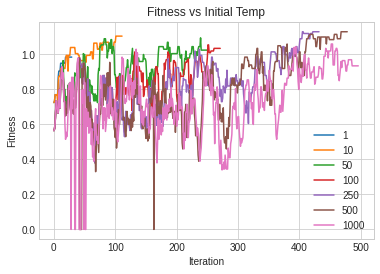

In [24]:
sa_curve['init_temp'] = sa_curve.Temperature.apply(lambda t: t.init_temp)
ax = None
fig = plt.figure()
for temp in init_temp:
    best_curve = sa_curve[sa_curve.init_temp == temp]
    # best_curve = rhc_curve.loc[(rhc_curve_restart.current_restart == best_restart_attempt) & (rhc_curve.Restarts == re)]
    best_curve.reset_index(inplace=True)
    best_curve['true_fit'] = best_curve.Fitness/200
    ax = best_curve['true_fit'].plot()
ax.set_xlabel("Iteration")
ax.set_ylabel("Fitness")
ax.legend(init_temp)
ax.set_title("Fitness vs Initial Temp")
fig.savefig(figure_dir + f"/{exp_name}_sa_init_temp.png")

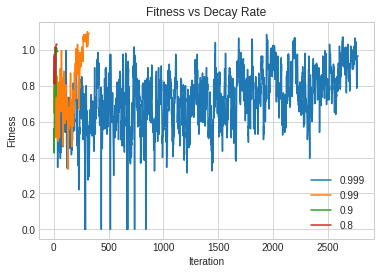

In [26]:
decay_rate = [0.999, 0.99, 0.9, 0.8]
out = None
fig = plt.figure()
for dr in decay_rate:
    schedule = GeomDecay(init_temp=250, decay=dr)
    s,f,curve = mlrose_hiive.simulated_annealing(problem,
                                                 schedule=schedule,
                                                 max_attempts=max_attempts,
                                                 max_iters=100000,
                                                 random_state=seed,
                                                 curve=True)
    df = pd.DataFrame(curve)
    df['true_fit'] = df[0]/200
    ax = df.true_fit.plot()
ax.set_xlabel("Iteration")
ax.set_ylabel("Fitness")
ax.legend(decay_rate)
ax.set_title("Fitness vs Decay Rate")
fig.savefig(figure_dir + f"/{exp_name}_sa_decay_rate.png")

In [27]:
population = [50, 100, 250, 500, 1000]
mutations_rates = [0.01, 0.1, 0.25, 0.5]

In [29]:
ga_population_runner = mlrose_hiive.GARunner(problem,
                                  seed=seed,
                                  output=output_dir,
                                  max_attempts=max_attempts,
                                  experiment_name=exp_name+'_population',
                                  iteration_list=[100000],
                                  population_sizes=population,
                                  mutation_rates=[0.1]
                                  )

ga_population_stats, ga_population_curve = ga_population_runner.run()

Running ga
*****************
*** Run START ***
*****************
pop_size:[50], mutation_prob:[0.1], max_iters:[100000], output:[output]
runner_name:[ga], experiment_name:[KS_population], attempt:[0], iteration:[0], done:[False], time:[0.00], fitness:[145.0000]
	[4 0 3 3 3 1 3 2 4 0]...

pop_size:[50], mutation_prob:[0.1], max_iters:[100000], output:[output]
runner_name:[ga], experiment_name:[KS_population], attempt:[11], iteration:[38], done:[True], time:[0.13], fitness:[231.0000]
	[0 3 3 4 4 4 0 4 4 4]...

***************
*** Run END ***
***************
*****************
*** Run START ***
*****************
pop_size:[100], mutation_prob:[0.1], max_iters:[100000], output:[output]
runner_name:[ga], experiment_name:[KS_population], attempt:[0], iteration:[0], done:[False], time:[0.00], fitness:[145.0000]
	[4 0 3 3 3 1 3 2 4 0]...

pop_size:[100], mutation_prob:[0.1], max_iters:[100000], output:[output]
runner_name:[ga], experiment_name:[KS_population], attempt:[11], iteration:[33], done:

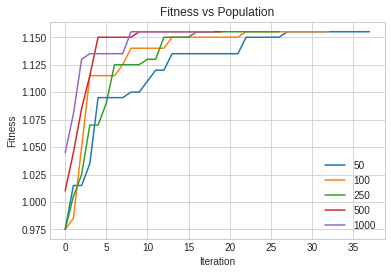

In [32]:
fig = plt.figure()

for ppl in population:
    best_curve = ga_population_curve[ga_population_curve['Population Size'] == ppl]
    best_curve.reset_index(inplace=True)
    best_curve['true_fit'] = best_curve.Fitness/200
    ax = best_curve['true_fit'].plot()
ax.set_xlabel("Iteration")
ax.set_ylabel("Fitness")
ax.legend(population)
ax.set_title("Fitness vs Population")
fig.savefig(figure_dir + f"/{exp_name}_ga_population.png")

In [33]:
ga_mut_runner = mlrose_hiive.GARunner(problem,
                                  seed=seed,
                                  output=output_dir,
                                  max_attempts=max_attempts,
                                  experiment_name=exp_name+'_mutation',
                                  iteration_list=[100000],
                                  population_sizes=[500],
                                  mutation_rates=mutations_rates
                                  )

ga_mut_stats, ga_mut_curve = ga_mut_runner.run()

Running ga
*****************
*** Run START ***
*****************
pop_size:[500], mutation_prob:[0.01], max_iters:[100000], output:[output]
runner_name:[ga], experiment_name:[KS_mutation], attempt:[0], iteration:[0], done:[False], time:[0.02], fitness:[145.0000]
	[4 0 3 3 3 1 3 2 4 0]...

pop_size:[500], mutation_prob:[0.01], max_iters:[100000], output:[output]
runner_name:[ga], experiment_name:[KS_mutation], attempt:[11], iteration:[22], done:[True], time:[0.74], fitness:[231.0000]
	[0 3 4 4 4 4 0 4 4 3]...

***************
*** Run END ***
***************
*****************
*** Run START ***
*****************
pop_size:[500], mutation_prob:[0.1], max_iters:[100000], output:[output]
runner_name:[ga], experiment_name:[KS_mutation], attempt:[0], iteration:[0], done:[False], time:[0.01], fitness:[145.0000]
	[4 0 3 3 3 1 3 2 4 0]...

pop_size:[500], mutation_prob:[0.1], max_iters:[100000], output:[output]
runner_name:[ga], experiment_name:[KS_mutation], attempt:[11], iteration:[20], done:[Tru

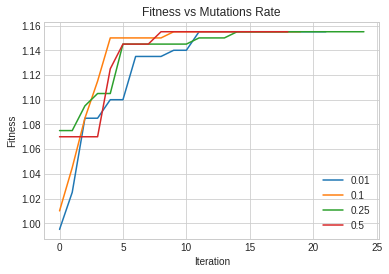

In [35]:
fig = plt.figure()
for mu in mutations_rates:
    best_curve = ga_mut_curve[ga_mut_curve['Mutation Rate'] == mu]
    best_curve.reset_index(inplace=True)
    best_curve['true_fit'] = best_curve.Fitness/200
    ax = best_curve['true_fit'].plot()
ax.set_xlabel("Iteration")
ax.set_ylabel("Fitness")
ax.legend(mutations_rates)
ax.set_title("Fitness vs Mutations Rate")
fig.savefig(figure_dir + f"/{exp_name}_ga_mutations.png")

In [ ]:
population = [100, 250, 500, 1000, 2000, 5000]
keep_percent = [0.01, 0.1, 0.2, 0.4, 0.6]

In [12]:
mimic_population_runner = mlrose_hiive.MIMICRunner(problem,
                                      seed=seed,
                                      output=output_dir,
                                      max_attempts=max_attempts,
                                      experiment_name=exp_name+'_population',
                                      iteration_list=[100000],
                                        population_sizes=population,
                                        keep_percent_list=[0.2])
mimic_population_stats, mimic_population_curve = mimic_population_runner.run()

Running mimic
*****************
*** Run START ***
*****************
use_fast_mimic:[False], pop_size:[100], keep_pct:[0.2], max_iters:[100000], output:[output]
runner_name:[mimic], experiment_name:[KS_population], attempt:[0], iteration:[0], done:[False], time:[0.00], fitness:[145.0000]
	[4 0 3 3 3 1 3 2 4 0]...

use_fast_mimic:[False], pop_size:[100], keep_pct:[0.2], max_iters:[100000], output:[output]
runner_name:[mimic], experiment_name:[KS_population], attempt:[11], iteration:[12], done:[True], time:[0.36], fitness:[223.0000]
	[3. 4. 4. 4. 4. 4. 1. 4. 3. 1.]...

***************
*** Run END ***
***************
*****************
*** Run START ***
*****************
use_fast_mimic:[False], pop_size:[250], keep_pct:[0.2], max_iters:[100000], output:[output]
runner_name:[mimic], experiment_name:[KS_population], attempt:[0], iteration:[0], done:[False], time:[0.01], fitness:[145.0000]
	[4 0 3 3 3 1 3 2 4 0]...

use_fast_mimic:[False], pop_size:[250], keep_pct:[0.2], max_iters:[100000], ou

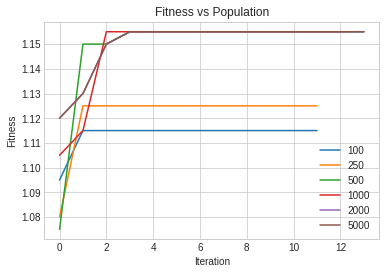

In [14]:
fig = plt.figure()

for ppl in population:
    best_curve = mimic_population_curve[mimic_population_curve['Population Size'] == ppl]
    best_curve.reset_index(inplace=True)
    best_curve['true_fit'] = best_curve.Fitness/200
    ax = best_curve['true_fit'].plot()
ax.set_xlabel("Iteration")
ax.set_ylabel("Fitness")
ax.legend(population)
ax.set_title("Fitness vs Population")
fig.savefig(figure_dir + f"/{exp_name}_mimic_population.png")


In [16]:
mimic_keep_runner = mlrose_hiive.MIMICRunner(problem,
                                      seed=seed,
                                      output=output_dir,
                                      max_attempts=max_attempts,
                                      experiment_name=exp_name+'_population',
                                      iteration_list=[100000],
                                        population_sizes=[2000],
                                        keep_percent_list=keep_percent)

mimic_keep_stats, mimic_keep_curve = mimic_keep_runner.run()




Running mimic
*****************
*** Run START ***
*****************
use_fast_mimic:[False], pop_size:[2000], keep_pct:[0.01], max_iters:[100000], output:[output]
runner_name:[mimic], experiment_name:[KS_population], attempt:[0], iteration:[0], done:[False], time:[0.05], fitness:[145.0000]
	[4 0 3 3 3 1 3 2 4 0]...

use_fast_mimic:[False], pop_size:[2000], keep_pct:[0.01], max_iters:[100000], output:[output]
runner_name:[mimic], experiment_name:[KS_population], attempt:[11], iteration:[11], done:[True], time:[0.61], fitness:[231.0000]
	[0. 3. 4. 4. 4. 4. 0. 4. 3. 4.]...

***************
*** Run END ***
***************
*****************
*** Run START ***
*****************
use_fast_mimic:[False], pop_size:[2000], keep_pct:[0.1], max_iters:[100000], output:[output]
runner_name:[mimic], experiment_name:[KS_population], attempt:[0], iteration:[0], done:[False], time:[0.04], fitness:[145.0000]
	[4 0 3 3 3 1 3 2 4 0]...

use_fast_mimic:[False], pop_size:[2000], keep_pct:[0.1], max_iters:[10000

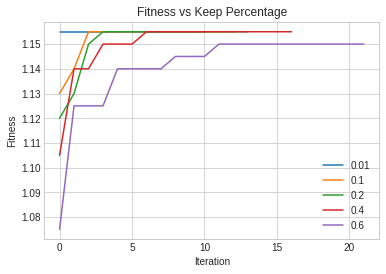

In [20]:
fig = plt.figure()
for kp in keep_percent:
    best_curve = mimic_keep_curve[mimic_keep_curve['Keep Percent'] == kp]
    best_curve.reset_index(inplace=True)
    best_curve['true_fit'] = best_curve.Fitness / 200
    ax = best_curve['true_fit'].plot()
ax.set_xlabel("Iteration")
ax.set_ylabel("Fitness")
ax.legend(keep_percent)
ax.set_title("Fitness vs Keep Percentage")
fig.savefig(figure_dir + f"/{exp_name}_mimic_keep.png")

      Iteration      Time  Fitness  Restarts  max_iters  current_restart  \
6296       6296  1.561315    177.0        90     100000               59   
6297       6297  1.561437    177.0        90     100000               59   
6298       6298  1.561558    179.0        90     100000               59   
6299       6299  1.561681    203.0        90     100000               59   
6300       6300  1.561801    203.0        90     100000               59   
6301       6301  1.561925    203.0        90     100000               59   
6302       6302  1.562050    203.0        90     100000               59   
6303       6303  1.562188    203.0        90     100000               59   
6304       6304  1.562327    221.0        90     100000               59   
6305       6305  1.562468    224.0        90     100000               59   
6306       6306  1.592058    224.0        90     100000               59   
6307       6307  1.592403    224.0        90     100000               59   
6308       6

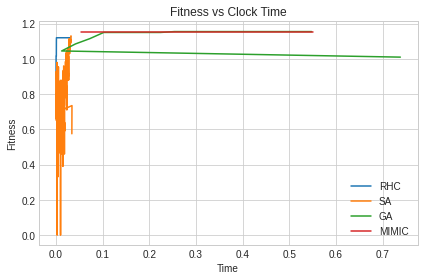

In [86]:
fig, ax = plt.subplots()

best_rhc_curve = rhc_curve[rhc_curve.Restarts == 90]
idx = best_rhc_curve.Fitness.idxmax()
best_restart_attempt = rhc_curve.iloc[idx].current_restart
best_rhc_curve = rhc_curve.loc[(best_rhc_curve.current_restart == best_restart_attempt) & (rhc_curve.Restarts == 90)]
best_rhc_curve['true_fit'] = best_rhc_curve.Fitness/200
best_rhc_curve['true_time'] = best_rhc_curve.Time - best_rhc_curve.iloc[0].Time
best_rhc_curve.plot(x='true_time', y='true_fit', ax=ax)
print(best_rhc_curve)
best_sa_curve = sa_curve[sa_curve.init_temp == 500]
best_sa_curve['true_fit'] =best_sa_curve.Fitness/200
best_sa_curve = best_sa_curve.iloc[1:]
best_sa_curve.plot(x='Time', y='true_fit',ax=ax)
# print(best_sa_curve.describe())

best_ga_curve = ga_mut_curve[ga_mut_curve['Mutation Rate'] == 0.1]
best_ga_curve['true_fit'] = best_ga_curve.Fitness / 200
# best_ga_curve = best_ga_curve.iloc[1:15]
best_ga_curve.plot(x='Time', y='true_fit',ax=ax)
# print(best_ga_curve)


best_mimic_curve = mimic_keep_curve[mimic_keep_curve['Keep Percent'] == 0.01]
best_mimic_curve['true_fit'] = best_mimic_curve.Fitness / 200
# best_mimic_curve = best_mimic_curve.iloc[1:15]

# print(best_mimic_curve)
best_mimic_curve.plot(x='Time', y='true_fit', ax=ax, xlabel='Time')
ax.legend(["RHC", "SA", "GA", "MIMIC"])
ax.set_xlabel("Time")
ax.set_ylabel("Fitness")
ax.set_title("Fitness vs Clock Time")
ax.get_figure().tight_layout()
fig.savefig(figure_dir + f"/{exp_name}_comp.png", transparent=False)

In [77]:
rhc_stats['true_fit'] = rhc_stats.Fitness/200
rhc_stats[rhc_stats.Restarts == 10].true_fit.max()
rhc_stats[rhc_stats.Restarts == 10].true_fit.idxmax()
rhc_stats.iloc[0]
# rhc_stats.Time.iloc[1] - rhc_stats.Time.iloc[0]

Iteration                                       0
Fitness                                       145
Time                                  0.000468108
State              [4, 0, 3, 3, 3, 1, 3, 2, 4, 0]
Restarts                                       10
max_iters                                  100000
current_restart                                 0
true_fit                                    0.725
Name: 0, dtype: object

In [79]:
sa_stats['true_fit'] = sa_stats.Fitness/200
sa_stats[sa_stats.schedule_init_temp == 500].true_fit.max()
sa_stats.Time[11] - sa_stats.Time[10]

0.033017663983628154

In [81]:
ga_population_stats.Fitness.max()/200
# ga_mut_stats.Fitness.max()/200
ga_mut_stats.Time.iloc[1] - ga_mut_stats.Time.iloc[0]

0.7184412679634988

In [87]:
mimic_keep_stats.Fitness.max()/200

mimic_keep_stats.Time.iloc[1] - mimic_keep_stats.Time.iloc[0]
mimic_keep_curve[mimic_keep_curve['Keep Percent'] == 0.01]

,Iteration,Time,Fitness,use_fast_mimic,Population Size,Keep Percent,max_iters,output
0,0,0.053209,231.0,False,2000,0.01,100000,output
1,1,0.101298,231.0,False,2000,0.01,100000,output
2,2,0.148543,231.0,False,2000,0.01,100000,output
3,3,0.195080,231.0,False,2000,0.01,100000,output
4,4,0.250175,231.0,False,2000,0.01,100000,output
5,5,0.300737,231.0,False,2000,0.01,100000,output
6,6,0.350842,231.0,False,2000,0.01,100000,output
7,7,0.400845,231.0,False,2000,0.01,100000,output
8,8,0.450769,231.0,False,2000,0.01,100000,output
9,9,0.500374,231.0,False,2000,0.01,100000,output
